# Data Processing - Extracting Information from 13D files
In the following, we want to extract the following information from the 13D files:
  * filing date
  * central index key of filer and subject company

With this information (cik of subject company and filing date of 13D), we will be able to link the 13D filings (via a cik-gvkey lookup table) to the corresponding LTS.  

## Preperation
Before we start by extracting information like the central index key of filing and subject company for all 13D filings, we need to identify patterns in the way this information is stored within the 13D files.

In [1]:
from HelperFunctions import printProgressBar, loadObject, dumpObject
from Definitions import EDGAR_RAW_DOWNLOADS, EDGAR_FIRST_STAGE, EDGAR_FIRST_STAGE_PROBLEM_FILES
import pandas as pd
import glob
import re
import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 400)

In [2]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

Let's have a look at a sample file.

In [3]:
with open(EDGAR_FIRST_STAGE / "0000002178-13-000051.txt", encoding = "utf-8") as file:
    content = file.read()
print(content)

0000002178-13-000051.txt : 20131122
0000002178-13-000051.hdr.sgml : 20131122
20131122142532
ACCESSION NUMBER:		0000002178-13-000051
CONFORMED SUBMISSION TYPE:	SC 13D
PUBLIC DOCUMENT COUNT:		3
FILED AS OF DATE:		20131122
DATE AS OF CHANGE:		20131122

SUBJECT COMPANY:	

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			ADAMS RESOURCES & ENERGY, INC.
		CENTRAL INDEX KEY:			0000002178
		STANDARD INDUSTRIAL CLASSIFICATION:	WHOLESALE-PETROLEUM & PETROLEUM PRODUCTS (NO BULK STATIONS) [5172]
		IRS NUMBER:				741753147
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			0926

	FILING VALUES:
		FORM TYPE:		SC 13D
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	005-13891
		FILM NUMBER:		131237851

	BUSINESS ADDRESS:	
		STREET 1:		17 S. BRIAR HOLLOW LN.
		CITY:			HOUSTON
		STATE:			TX
		ZIP:			77027
		BUSINESS PHONE:		7138813600

	MAIL ADDRESS:	
		STREET 1:		P O BOX 844
		CITY:			HOUSTON
		STATE:			TX
		ZIP:			77001

	FORMER COMPANY:	
		FORMER CONFORMED NAME:	ADAMS RESOURCES & ENERGY INC
		DATE OF NAME CHANGE:	

We see that at the beginning of each file, there seams to be a header with all the relevant information.
Usually data is presented in the following way: 

*DescriptionOfValue*: *Value*

In the following we will refer to the *DescriptionOfValue* as *keyword*.

To search for the number of occurences of a specific keyword and to determine the value written after a keyword, we will define the following two generic functions:

In [4]:
def findNrOfKeyword(keyword, file):
    keyword_occ = 0
    with open(file, encoding = "utf-8") as file:
        content = file.readlines()
    for line in content:
        if keyword in line:
            keyword_occ += 1
    return keyword_occ

def getValuesFromFileAfterColumn(keyword, file):
    values = []
    with open(file, encoding = "utf-8") as file:
        content = file.readlines()
    for line in content:
        if keyword in line:
            values.append(line.split(":")[-1].replace('\t', '').replace('\n', ''))  #remove \t and \n from string
    return values


## Filing date
We can see, that right at the top there is the keyword "FILED AS OF DATE" followed by a column sign and the date. Let's see, if all the filings contain this keyword:

In [5]:
all_files = glob.glob(str(EDGAR_FIRST_STAGE / "*.txt"))
filing_dates = []
for index, file in enumerate(all_files):
    printProgressBar(index+1, len(all_files), prefix = "Progress", suffix = "Complete", length = 50)
    filing_dates.append(findNrOfKeyword("FILED AS OF DATE", file))
data_tuples = list(zip(all_files,filing_dates))
df_file_filing_dates = pd.DataFrame(data_tuples, columns=['FilePath','FiledAsOfDate'])

Progress |██████████████████████████████████████████████████| 100.0% Complete


In [6]:
df_file_filing_dates

FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53831  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-001433.txt   
53832  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004652.txt   
53833  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004656.txt   
53834  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004658.txt   
53835  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004661.txt   

       FiledAsOfDate  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
...              ...  
53831              1  
53832              1  
53833              1  
53834              1  
53835              1  

[53836 rows x 2 columns]

In [7]:
print(df_file_filing_dates["FiledAsOfDate"].value_counts())

1    53770
0       43
2       23
Name: FiledAsOfDate, dtype: int64


We see, that there are 53,770 that as expected only contain the keyword "FILED AS OF DATE" once. In the following section we will have a short look at the outliers, which are the files where the keyword either never appeared or appeared twice. 

### 0 matches

The following algorithm picks a random file, that does not contain the keyword "FILED AS OF DATE". You can view a new random file simply be executing the algorithm again.

In [8]:
sample = df_file_filing_dates[df_file_filing_dates["FiledAsOfDate"] == 0].sample()
with open(sample["FilePath"].iloc[0], encoding = "utf-8") as file:
    content = file.read()
print(content)

<DOCUMENT>
<TYPE>SC 13D
<SEQUENCE>1
<DESCRIPTION>INITIAL SCHEDULE 13D
<TEXT>

               SECURITIES AND EXCHANGE COMMISSION
                     Washington, D.C.  20549
                                
                                                
                          SCHEDULE 13D
                                
                                
                                                
            Under the Securities Exchange Act of 1934
                                 
                         Multimedia, Inc.            
                        (Name of Issuer)
                                
                        
             Common Stock Par Value $0.10 Per Share     
                (Title of Class and Securities) 
                                
                                                
                           62545K107                  
              (CUSIP Number of Class of Securities)
                                                
      

An investigation of 10 random files concluded, that all of these files were filed either in 1995 or 1996. The keyword used in these files is: 

    Date of Event which Requires Filing of this Statement 

Due to the fact that the oldest 13D Filings that will be used in our subsequent analysis are from the year 1998 (see thesis), we can drop these files without having to fear any potential consequences for the subsequent analysis.

### 2 matches
Analogous to the analysis for 0 matches, we take random samples of files that contain the keyword "FILED AS OF DATE" twice.

In [9]:
sample = df_file_filing_dates[df_file_filing_dates["FiledAsOfDate"] == 2].sample()
with open(sample["FilePath"].iloc[0], encoding = "utf-8") as file:
    content = file.read()
print(content)

-----BEGIN PRIVACY-ENHANCED MESSAGE-----
Proc-Type: 2001,MIC-CLEAR
Originator-Name: webmaster@www.sec.gov
Originator-Key-Asymmetric:
 MFgwCgYEVQgBAQICAf8DSgAwRwJAW2sNKK9AVtBzYZmr6aGjlWyK3XmZv3dTINen
 TWSM7vrzLADbmYQaionwg5sDW3P6oaM5D3tdezXMm7z1T+B+twIDAQAB
MIC-Info: RSA-MD5,RSA,
 NIcInzoyvheI8DYecwL8rM0VROKsZIvpXW+rMmkfh9ZG6xfzzZqpOXbHNm372m4i
 VLJG3HW95WWXj0MbLYXmmQ==

<SEC-DOCUMENT>0000950123-95-002740.txt : 19950928
<SEC-HEADER>0000950123-95-002740.hdr.sgml : 19950927
ACCESSION NUMBER:		0000950123-95-002740
CONFORMED SUBMISSION TYPE:	SC 13D
PUBLIC DOCUMENT COUNT:		1
FILED AS OF DATE:		19950925
SROS:			NYSE

SUBJECT COMPANY:	

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			ROUSE COMPANY
		CENTRAL INDEX KEY:			0000085388
		STANDARD INDUSTRIAL CLASSIFICATION:	OPERATORS OF NONRESIDENTIAL BUILDINGS [6512]
		IRS NUMBER:				520735512
		STATE OF INCORPORATION:			MD
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		SC 13D
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	005-10594
		FILM NUMBER:		

Let's investigate, if the filing date is the same if it occurs twice.

In [10]:
all_files_fd_2 = df_file_filing_dates[df_file_filing_dates["FiledAsOfDate"] == 2]["FilePath"]
filing_dates = []
for index, file in enumerate(all_files_fd_2):
    printProgressBar(index+1, len(all_files_fd_2), prefix = "Progress", suffix = "Complete", length = 50)
    filing_dates.append(getValuesFromFileAfterColumn("FILED AS OF DATE",file))
data_tuples = list(zip(all_files_fd_2,filing_dates))
df_file_ = pd.DataFrame(data_tuples, columns=['FilePath','FiledAsOfDate'])

Progress |██████████████████████████████████████████████████| 100.0% Complete


In [11]:
df_file_["FiledAsOfDateReduced"] = list(map(lambda x: list(set(x)), df_file_["FiledAsOfDate"]))
df_file_

FilePath  \
0   E:\00_git\invact\internal_Data\edgar\first_stage\0000705003-98-000027.txt   
1   E:\00_git\invact\internal_Data\edgar\first_stage\0000705003-98-000028.txt   
2   E:\00_git\invact\internal_Data\edgar\first_stage\0000807249-95-000160.txt   
3   E:\00_git\invact\internal_Data\edgar\first_stage\0000899140-95-000224.txt   
4   E:\00_git\invact\internal_Data\edgar\first_stage\0000902664-98-000176.txt   
5   E:\00_git\invact\internal_Data\edgar\first_stage\0000919567-98-000043.txt   
6   E:\00_git\invact\internal_Data\edgar\first_stage\0000938492-98-000252.txt   
7   E:\00_git\invact\internal_Data\edgar\first_stage\0000950112-95-002510.txt   
8   E:\00_git\invact\internal_Data\edgar\first_stage\0000950123-95-002740.txt   
9   E:\00_git\invact\internal_Data\edgar\first_stage\0000950123-98-006045.txt   
10  E:\00_git\invact\internal_Data\edgar\first_stage\0000950144-98-007525.txt   
11  E:\00_git\invact\internal_Data\edgar\first_stage\0001019056-98-000347.txt   
12  E:\00_git\invact\internal_Data\edgar\first_stage\0001019056-98-000349.txt   
13  E:\00_git\invact\internal_Data\edgar\first_stage\0001034603-98-000034.txt   
14  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000056.txt   
15  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000057.txt   
16  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000058.txt   
17  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000059.txt   
18  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000060.txt   
19  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000061.txt   
20  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000070.txt   
21  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000090.txt   
22  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000107.txt   

           FiledAsOfDate  FiledAsOfDateReduced  
0   [19980617, 19980617]            [19980617]  
1   [19980617, 19980617]            [19980617]  
2   [19950925, 19950925]            [19950925]  
3   [19950925, 19950925]            [19950925]  
4   [19980617, 19980617]            [19980617]  
5   [19980617, 19980617]            [19980617]  
6   [19980617, 19980617]            [19980617]  
7   [19950925, 19950925]            [19950925]  
8   [19950925, 19950925]            [19950925]  
9   [19980617, 19980617]            [19980617]  
10  [19980617, 19980617]            [19980617]  
11  [19980617, 19980617]            [19980617]  
12  [19980617, 19980617]            [19980617]  
13  [19980617, 19980617]            [19980617]  
14  [20090406, 20090403]  [20090406, 20090403]  
15  [20090406, 20090403]  [20090406, 20090403]  
16  [20090406, 20090403]  [20090406, 20090403]  
17  [20090407, 20090407]            [20090407]  
18  [20090407, 20090407]            [20090407]  
19  [20090408, 20090407]  [20090408, 20090407]  
20  [20090410, 20090410]            [20090410]  
21  [20090417, 20090416]  [20090417, 20090416]  
22  [20090506, 20090506]            [20090506]

We can already see, that for many files that the dates are the same. The following algorithm checks if this is the case. If it is, it collapses the list.

In [12]:
df_file_["NrOfFiledAsOfDateReduced"] = list(map(lambda x: len(x), df_file_["FiledAsOfDateReduced"]))
df_file_

FilePath  \
0   E:\00_git\invact\internal_Data\edgar\first_stage\0000705003-98-000027.txt   
1   E:\00_git\invact\internal_Data\edgar\first_stage\0000705003-98-000028.txt   
2   E:\00_git\invact\internal_Data\edgar\first_stage\0000807249-95-000160.txt   
3   E:\00_git\invact\internal_Data\edgar\first_stage\0000899140-95-000224.txt   
4   E:\00_git\invact\internal_Data\edgar\first_stage\0000902664-98-000176.txt   
5   E:\00_git\invact\internal_Data\edgar\first_stage\0000919567-98-000043.txt   
6   E:\00_git\invact\internal_Data\edgar\first_stage\0000938492-98-000252.txt   
7   E:\00_git\invact\internal_Data\edgar\first_stage\0000950112-95-002510.txt   
8   E:\00_git\invact\internal_Data\edgar\first_stage\0000950123-95-002740.txt   
9   E:\00_git\invact\internal_Data\edgar\first_stage\0000950123-98-006045.txt   
10  E:\00_git\invact\internal_Data\edgar\first_stage\0000950144-98-007525.txt   
11  E:\00_git\invact\internal_Data\edgar\first_stage\0001019056-98-000347.txt   
12  E:\00_git\invact\internal_Data\edgar\first_stage\0001019056-98-000349.txt   
13  E:\00_git\invact\internal_Data\edgar\first_stage\0001034603-98-000034.txt   
14  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000056.txt   
15  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000057.txt   
16  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000058.txt   
17  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000059.txt   
18  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000060.txt   
19  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000061.txt   
20  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000070.txt   
21  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000090.txt   
22  E:\00_git\invact\internal_Data\edgar\first_stage\0001456907-09-000107.txt   

           FiledAsOfDate  FiledAsOfDateReduced  NrOfFiledAsOfDateReduced  
0   [19980617, 19980617]            [19980617]                         1  
1   [19980617, 19980617]            [19980617]                         1  
2   [19950925, 19950925]            [19950925]                         1  
3   [19950925, 19950925]            [19950925]                         1  
4   [19980617, 19980617]            [19980617]                         1  
5   [19980617, 19980617]            [19980617]                         1  
6   [19980617, 19980617]            [19980617]                         1  
7   [19950925, 19950925]            [19950925]                         1  
8   [19950925, 19950925]            [19950925]                         1  
9   [19980617, 19980617]            [19980617]                         1  
10  [19980617, 19980617]            [19980617]                         1  
11  [19980617, 19980617]            [19980617]                         1  
12  [19980617, 19980617]            [19980617]                         1  
13  [19980617, 19980617]            [19980617]                         1  
14  [20090406, 20090403]  [20090406, 20090403]                         2  
15  [20090406, 20090403]  [20090406, 20090403]                         2  
16  [20090406, 20090403]  [20090406, 20090403]                         2  
17  [20090407, 20090407]            [20090407]                         1  
18  [20090407, 20090407]            [20090407]                         1  
19  [20090408, 20090407]  [20090408, 20090407]                         2  
20  [20090410, 20090410]            [20090410]                         1  
21  [20090417, 20090416]  [20090417, 20090416]                         2  
22  [20090506, 20090506]            [20090506]                         1

Now let's take a look at the files, that still show two filing dates. Let's copy all these files to a new dataframe:

In [13]:
error_files = df_file_[df_file_["NrOfFiledAsOfDateReduced"] == 2]

Now, let's use the following algorithm to investigate random files from within this list of problem files.

In [14]:
sample = error_files.sample()
with open(sample["FilePath"].iloc[0], encoding = "utf-8") as file:
    content = file.read()
print(content)

-----BEGIN PRIVACY-ENHANCED MESSAGE-----
Proc-Type: 2001,MIC-CLEAR
Originator-Name: webmaster@www.sec.gov
Originator-Key-Asymmetric:
 MFgwCgYEVQgBAQICAf8DSgAwRwJAW2sNKK9AVtBzYZmr6aGjlWyK3XmZv3dTINen
 TWSM7vrzLADbmYQaionwg5sDW3P6oaM5D3tdezXMm7z1T+B+twIDAQAB
MIC-Info: RSA-MD5,RSA,
 IGnd7ykSXJtIOaHdvfVf/8Z8HzBebjg3psHfOGOzyvHyUufm72VpcwijzCkkRLA6
 Uhsi2+2M6oBhDpYOzKFBIw==

<SEC-DOCUMENT>0001456907-09-000058.txt : 20090406
<SEC-HEADER>0001456907-09-000058.hdr.sgml : 20090406
<ACCEPTANCE-DATETIME>20090403214709
ACCESSION NUMBER:		0001456907-09-000058
CONFORMED SUBMISSION TYPE:	SC 13D
PUBLIC DOCUMENT COUNT:		1
FILED AS OF DATE:		20090406
GROUP MEMBERS:		JAYCEE JAMES

SUBJECT COMPANY:	

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			CORNET STORES
		CENTRAL INDEX KEY:			0000024734
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-VARIETY STORES [5331]
		IRS NUMBER:				95149035
		FISCAL YEAR END:			0531

	FILING VALUES:
		FORM TYPE:		SC 13D
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	005-33848
		FILM NUMBE

Our investigation suspects, that the earlier date out of the two corresponds to the real filings date. Whether the later date corresponds to the date, where the filing has been accepted by the SEC or a date, where a change was made, we cannot tell.
However, we note, that the two dates are very close to each other (no more than 3 days). As our subsequent analysis is not dependant on the exact filing date within a month, we will use the first date out of these two as the filing date.

## Central index key (cik)

We can see that right in the beginning we have two different sections "Subject company" and "Filed by", each containing the cik of the corresponding firm. The cik can be found after the keyword "CENTRAL INDEX KEY" and a column. 
If this format is the same for all files, we should have 2 hits for each file for the following search: 

### Naming order
Although for many files we see that the subject company is stated before the filing company, this is not always the case. To get more insight into the order and the number, to which subject companies and filing companies are stated, we define and run the following function.

In [16]:
def getOrderOfCIKs(filename):
    sc_line = []
    fc_line = []
    with open(filename, encoding = "utf-8") as file:
        content = file.readlines()
    for index, line in enumerate(content):
        if "SUBJECT COMPANY:" in line:
            sc_line.append(index)
        elif "FILED BY:" in line:
            fc_line.append(index)
    return sc_line, fc_line

all_files = glob.glob(str(EDGAR_FIRST_STAGE / "*.txt"))
company_order = []
for index, file in enumerate(all_files):
    printProgressBar(index+1, len(all_files), prefix = "Progress", suffix = "Complete", length = 50)
    company_order.append(getOrderOfCIKs(file))
data_tuples = list(zip(all_files, company_order))
df_file_ciks = pd.DataFrame(data_tuples, columns=['FilePath', 'CompanyOrderScFc'])
df_file_ciks

Progress |--------------------------------------------------| 0.5% Complete

Progress |██████████████████████████████████████████████████| 100.0% Complete


FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53831  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-001433.txt   
53832  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004652.txt   
53833  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004656.txt   
53834  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004658.txt   
53835  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004661.txt   

      CompanyOrderScFc  
0         ([17], [53])  
1         ([18], [38])  
2          ([9], [46])  
3          ([9], [46])  
4          ([8], [36])  
...                ...  
53831   ([20, 49], [])  
53832   ([20, 55], [])  
53833   ([20, 55], [])  
53834   ([20, 55], [])  
53835   ([20, 55], [])  

[53836 rows x 2 columns]

In [17]:
df_file_ciks["CompanyNamings"] = list(map(lambda x: [len(x[0]), len(x[1])], df_file_ciks["CompanyOrderScFc"]))
df_file_ciks

FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53831  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-001433.txt   
53832  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004652.txt   
53833  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004656.txt   
53834  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004658.txt   
53835  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004661.txt   

      CompanyOrderScFc CompanyNamings  
0         ([17], [53])         [1, 1]  
1         ([18], [38])         [1, 1]  
2          ([9], [46])         [1, 1]  
3          ([9], [46])         [1, 1]  
4          ([8], [36])         [1, 1]  
...                ...            ...  
53831   ([20, 49], [])         [2, 0]  
53832   ([20, 55], [])         [2, 0]  
53833   ([20, 55], [])         [2, 0]  
53834   ([20, 55], [])         [2, 0]  
53835   ([20, 55], [])         [2, 0]  

[53836 rows x 3 columns]

Let's get the statistics:

In [18]:
df_file_ciks["CompanyNamings"].value_counts()

[1, 1]    53648
[1, 0]       89
[0, 0]       43
[2, 2]       30
[2, 0]       16
[1, 2]        5
[2, 1]        4
[4, 1]        1
Name: CompanyNamings, dtype: int64

We see that for 53,648 files the term subject company and filing company is as expected stated once.
The other files state these terms either too many or few times and are therefore disregarded for the subsequent analysis. 

Therefore, we add a column that marks these entries. 

In [19]:
df_file_ciks["ToBeDisregardedDueToNamingOrder"] = list(map(lambda x: 0 if x == [1,1] else 1 , df_file_ciks["CompanyNamings"]))
df_file_ciks

FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53831  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-001433.txt   
53832  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004652.txt   
53833  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004656.txt   
53834  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004658.txt   
53835  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004661.txt   

      CompanyOrderScFc CompanyNamings  ToBeDisregardedDueToNamingOrder  
0         ([17], [53])         [1, 1]                                0  
1         ([18], [38])         [1, 1]                                0  
2          ([9], [46])         [1, 1]                                0  
3          ([9], [46])         [1, 1]                                0  
4          ([8], [36])         [1, 1]                                0  
...                ...            ...                              ...  
53831   ([20, 49], [])         [2, 0]                                1  
53832   ([20, 55], [])         [2, 0]                                1  
53833   ([20, 55], [])         [2, 0]                                1  
53834   ([20, 55], [])         [2, 0]                                1  
53835   ([20, 55], [])         [2, 0]                                1  

[53836 rows x 4 columns]

In [20]:
df_file_ciks["ToBeDisregardedDueToNamingOrder"].value_counts()

0    53648
1      188
Name: ToBeDisregardedDueToNamingOrder, dtype: int64

## Number of cik keyword matches
Now we investigate how many times the cik keyword (*CENTRAL INDEX KEY*) is stated in the 13D filings.

In [21]:
def findNrOfCIKs(file):
    cik = 0
    with open(file, encoding = "utf-8") as file:
        content = file.readlines()
    for line in content:
        if "CENTRAL INDEX KEY" in line:
            cik += 1
    return cik

all_files = glob.glob(str(EDGAR_FIRST_STAGE / "*.txt"))
ciks = []
for index, file in enumerate(all_files):
    printProgressBar(index+1, len(all_files), prefix = "Progress", suffix = "Complete", length = 50)
    ciks.append(findNrOfCIKs(file))
    company_order.append(getOrderOfCIKs(file))
data_tuples = list(zip(all_files,ciks))
df_file_ciks_temp = pd.DataFrame(data_tuples, columns=['FilePath','NrOfCIKKeyword'])
df_file_ciks = pd.merge(df_file_ciks, df_file_ciks_temp, how = "left", left_on = ["FilePath"], \
                                right_on = ["FilePath"])

Progress |--------------------------------------------------| 0.3% Complete

Progress |██████████████████████████████████████████████████| 100.0% Complete


In [22]:
df_file_ciks

FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53831  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-001433.txt   
53832  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004652.txt   
53833  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004656.txt   
53834  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004658.txt   
53835  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004661.txt   

      CompanyOrderScFc CompanyNamings  ToBeDisregardedDueToNamingOrder  \
0         ([17], [53])         [1, 1]                                0   
1         ([18], [38])         [1, 1]                                0   
2          ([9], [46])         [1, 1]                                0   
3          ([9], [46])         [1, 1]                                0   
4          ([8], [36])         [1, 1]                                0   
...                ...            ...                              ...   
53831   ([20, 49], [])         [2, 0]                                1   
53832   ([20, 55], [])         [2, 0]                                1   
53833   ([20, 55], [])         [2, 0]                                1   
53834   ([20, 55], [])         [2, 0]                                1   
53835   ([20, 55], [])         [2, 0]                                1   

       NrOfCIKKeyword  
0                   2  
1                   2  
2                   2  
3                   2  
4                   2  
...               ...  
53831               2  
53832               2  
53833               2  
53834               2  
53835               2  

[53836 rows x 5 columns]

In [23]:
print(df_file_ciks["NrOfCIKKeyword"].value_counts())

2    53664
1       89
0       43
4       23
3       17
Name: NrOfCIKKeyword, dtype: int64


So, we have 53.664 files, that contain exactly the keywords that we want two times as expected.
However, there 43 files where the CENTRAL INDEX KEY keyword hasn't even been mentioned once. Also in 89 files, it has only been metioned once.
On the other hand we also have 17 files, where it has been mentioned three times and 23 files, where it has been mentioned 4 times.
For our further analysis we will disregard all files, that do not contain exactly 2 ciks:

In [24]:
df_file_ciks["ToBeDisregardedDueToNrOfCIKStatements"] = list(map(lambda x: 0 if x == 2 else 1 , df_file_ciks["NrOfCIKKeyword"]))
df_file_ciks

FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53831  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-001433.txt   
53832  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004652.txt   
53833  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004656.txt   
53834  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004658.txt   
53835  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004661.txt   

      CompanyOrderScFc CompanyNamings  ToBeDisregardedDueToNamingOrder  \
0         ([17], [53])         [1, 1]                                0   
1         ([18], [38])         [1, 1]                                0   
2          ([9], [46])         [1, 1]                                0   
3          ([9], [46])         [1, 1]                                0   
4          ([8], [36])         [1, 1]                                0   
...                ...            ...                              ...   
53831   ([20, 49], [])         [2, 0]                                1   
53832   ([20, 55], [])         [2, 0]                                1   
53833   ([20, 55], [])         [2, 0]                                1   
53834   ([20, 55], [])         [2, 0]                                1   
53835   ([20, 55], [])         [2, 0]                                1   

       NrOfCIKKeyword  ToBeDisregardedDueToNrOfCIKStatements  
0                   2                                      0  
1                   2                                      0  
2                   2                                      0  
3                   2                                      0  
4                   2                                      0  
...               ...                                    ...  
53831               2                                      0  
53832               2                                      0  
53833               2                                      0  
53834               2                                      0  
53835               2                                      0  

[53836 rows x 6 columns]

In [25]:
df_file_ciks["ToBeDisregardedDueToNrOfCIKStatements"].value_counts()

0    53664
1      172
Name: ToBeDisregardedDueToNrOfCIKStatements, dtype: int64

## Combining all the data
In the following we will merge both dataframes (filing data & cik).
We will merge by *FilePath*, which works as a unique identifier for each file.

In [26]:
df_file_filing_dates

FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53831  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-001433.txt   
53832  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004652.txt   
53833  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004656.txt   
53834  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004658.txt   
53835  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004661.txt   

       FiledAsOfDate  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
...              ...  
53831              1  
53832              1  
53833              1  
53834              1  
53835              1  

[53836 rows x 2 columns]

In [27]:
df_file_ciks

FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53831  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-001433.txt   
53832  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004652.txt   
53833  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004656.txt   
53834  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004658.txt   
53835  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004661.txt   

      CompanyOrderScFc CompanyNamings  ToBeDisregardedDueToNamingOrder  \
0         ([17], [53])         [1, 1]                                0   
1         ([18], [38])         [1, 1]                                0   
2          ([9], [46])         [1, 1]                                0   
3          ([9], [46])         [1, 1]                                0   
4          ([8], [36])         [1, 1]                                0   
...                ...            ...                              ...   
53831   ([20, 49], [])         [2, 0]                                1   
53832   ([20, 55], [])         [2, 0]                                1   
53833   ([20, 55], [])         [2, 0]                                1   
53834   ([20, 55], [])         [2, 0]                                1   
53835   ([20, 55], [])         [2, 0]                                1   

       NrOfCIKKeyword  ToBeDisregardedDueToNrOfCIKStatements  
0                   2                                      0  
1                   2                                      0  
2                   2                                      0  
3                   2                                      0  
4                   2                                      0  
...               ...                                    ...  
53831               2                                      0  
53832               2                                      0  
53833               2                                      0  
53834               2                                      0  
53835               2                                      0  

[53836 rows x 6 columns]

In [28]:
df_13d_files_numbers = pd.merge(df_file_filing_dates, df_file_ciks, how = "left", left_on = ["FilePath"], \
                                right_on = ["FilePath"])
df_13d_files_numbers

FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53831  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-001433.txt   
53832  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004652.txt   
53833  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004656.txt   
53834  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004658.txt   
53835  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-05-004661.txt   

       FiledAsOfDate CompanyOrderScFc CompanyNamings  \
0                  1     ([17], [53])         [1, 1]   
1                  1     ([18], [38])         [1, 1]   
2                  1      ([9], [46])         [1, 1]   
3                  1      ([9], [46])         [1, 1]   
4                  1      ([8], [36])         [1, 1]   
...              ...              ...            ...   
53831              1   ([20, 49], [])         [2, 0]   
53832              1   ([20, 55], [])         [2, 0]   
53833              1   ([20, 55], [])         [2, 0]   
53834              1   ([20, 55], [])         [2, 0]   
53835              1   ([20, 55], [])         [2, 0]   

       ToBeDisregardedDueToNamingOrder  NrOfCIKKeyword  \
0                                    0               2   
1                                    0               2   
2                                    0               2   
3                                    0               2   
4                                    0               2   
...                                ...             ...   
53831                                1               2   
53832                                1               2   
53833                                1               2   
53834                                1               2   
53835                                1               2   

       ToBeDisregardedDueToNrOfCIKStatements  
0                                          0  
1                                          0  
2                                          0  
3                                          0  
4                                          0  
...                                      ...  
53831                                      0  
53832                                      0  
53833                                      0  
53834                                      0  
53835                                      0  

[53836 rows x 7 columns]

We only want to select the rows, that we didn't mark to be disregarded.

In [29]:
df_13d_files_numbers_filtered = df_13d_files_numbers[(df_13d_files_numbers["ToBeDisregardedDueToNamingOrder"] == 0) &
                                                     (df_13d_files_numbers["ToBeDisregardedDueToNrOfCIKStatements"] == 0) &
                                                     (df_13d_files_numbers["FiledAsOfDate"] > 0)]

df_13d_files_numbers_filtered

FilePath  \
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt   
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt   
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt   
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt   
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt   
...                                                                          ...   
53726  E:\00_git\invact\internal_Data\edgar\first_stage\0001720578-17-000004.txt   
53727  E:\00_git\invact\internal_Data\edgar\first_stage\0001728380-18-000003.txt   
53728  E:\00_git\invact\internal_Data\edgar\first_stage\0001733439-18-000008.txt   
53730  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-02-005664.txt   
53731  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-02-006320.txt   

       FiledAsOfDate CompanyOrderScFc CompanyNamings  \
0                  1     ([17], [53])         [1, 1]   
1                  1     ([18], [38])         [1, 1]   
2                  1      ([9], [46])         [1, 1]   
3                  1      ([9], [46])         [1, 1]   
4                  1      ([8], [36])         [1, 1]   
...              ...              ...            ...   
53726              1      ([9], [42])         [1, 1]   
53727              1     ([12], [41])         [1, 1]   
53728              1      ([8], [38])         [1, 1]   
53730              1     ([18], [38])         [1, 1]   
53731              1     ([18], [46])         [1, 1]   

       ToBeDisregardedDueToNamingOrder  NrOfCIKKeyword  \
0                                    0               2   
1                                    0               2   
2                                    0               2   
3                                    0               2   
4                                    0               2   
...                                ...             ...   
53726                                0               2   
53727                                0               2   
53728                                0               2   
53730                                0               2   
53731                                0               2   

       ToBeDisregardedDueToNrOfCIKStatements  
0                                          0  
1                                          0  
2                                          0  
3                                          0  
4                                          0  
...                                      ...  
53726                                      0  
53727                                      0  
53728                                      0  
53730                                      0  
53731                                      0  

[53644 rows x 7 columns]

For these files, we extract the information.

In [30]:
# This function searches for all the CIKs in the file.
# It also takes into account the order in which the CIK is stated in the file. (subject company, then filing company) 
# or (filing company, subject company)
# returns a list (cik_sc, cik_fc)
def getCIKNrs(filename):
    cikNrs = []
    with open(filename, encoding = "utf-8") as file:
        content = file.readlines()
    for line in content:
        if "CENTRAL INDEX KEY" in line:
            CIK_line = line.split(":")
            if len(CIK_line) > 1: # making sure, that there is an actual value after the keyword
                cikNrs.append(CIK_line[-1].replace('\t', '').replace('\n', ''))  #remove \t and \n from string
    sc_line, fc_line = getOrderOfCIKs(filename)
    if sc_line[0] < fc_line[0]: #subject company is stated first. 
        return cikNrs
    elif sc_line[0] > fc_line[0]: #filing company is stated first.
        cikNrs.reverse()
        return cikNrs

# This function also takes into account the cases, where we have 2 matches. (see beginning of page)
# More specific and sophisticated than the getValuesFromFileAfterColumn() function.
def getFilingDate(filename):
    values = []
    value = -1
    with open(filename, encoding = "utf-8") as file:
        content = file.readlines()
    for line in content:
        if "FILED AS OF DATE" in line:
            values.append(line.split(":")[-1].replace('\t', '').replace('\n', ''))  #remove \t and \n from string
    if len(values) == 1:
        value = values[0]
    elif len(values) == 2:
        if int(values[0]) < int(values[1]): #use earlier date
            value = values[0]
        else:
            value = values[1]
    return value

    
all_files = df_13d_files_numbers_filtered["FilePath"]
filing_dates = []
ciks_sc = []
ciks_fc = []
filePaths = []
for index, file in enumerate(all_files):
    printProgressBar(index+1, len(all_files), prefix = "Progress", suffix = "Complete", length = 50)
    filing_dates.append(getFilingDate(file))
    ciks = getCIKNrs(file)
    ciks_sc.append(int(ciks[0]))
    ciks_fc.append(int(ciks[1]))
    filePaths.append(file)
data_tuples = list(zip(filing_dates,ciks_sc,ciks_fc, filePaths))
df_13d_files = pd.DataFrame(data_tuples, columns=["13d_filing_date","13d_cik_sc", "13d_cik_fc", "13d_filePath"])
df_13d_files

Progress |██████████████████████████████████████████████████| 100.0% Complete


13d_filing_date  13d_cik_sc  13d_cik_fc  \
0            20000526      893739     1100884   
1            19950503      867941      318989   
2            20131122        2178     1591857   
3            20131122        2178     1591863   
4            20131122     1591522        2178   
...               ...         ...         ...   
53639        20171227      896985     1720578   
53640        20180118      879635     1728380   
53641        20180406     1733439     1733439   
53642        20020122     1165873     1165873   
53643        20020128     1003565      898286   

                                                                    13d_filePath  
0      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-00-011949.txt  
1      E:\00_git\invact\internal_Data\edgar\first_stage\0000000000-95-000911.txt  
2      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000051.txt  
3      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000053.txt  
4      E:\00_git\invact\internal_Data\edgar\first_stage\0000002178-13-000055.txt  
...                                                                          ...  
53639  E:\00_git\invact\internal_Data\edgar\first_stage\0001720578-17-000004.txt  
53640  E:\00_git\invact\internal_Data\edgar\first_stage\0001728380-18-000003.txt  
53641  E:\00_git\invact\internal_Data\edgar\first_stage\0001733439-18-000008.txt  
53642  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-02-005664.txt  
53643  E:\00_git\invact\internal_Data\edgar\first_stage\9999999997-02-006320.txt  

[53644 rows x 4 columns]

Now we extract the filing year and the filing month from the filing date and store them in seperate columns.

In [31]:
print("Mapping 13D filings to financial year.")
df_13d_files["13d_filingYear"] = list(map(lambda d: datetime.datetime.strptime(d, "%Y%m%d").year, df_13d_files["13d_filing_date"]))
df_13d_files["13d_filingMonth"] = list(map(lambda d: datetime.datetime.strptime(d, "%Y%m%d").month, df_13d_files["13d_filing_date"]))
print("Finished mapping 13D filings to financial year and month.")

Mapping 13D filings to financial year.
Finished mapping 13D filings to financial year and month.


In [32]:
dumpObject(df_13d_files, "df_13d_files")

### Filing Year - Descriptive Statistic

In [33]:
df_13d_files['13d_filingYear'].value_counts().sort_index()

1994     177
1995     774
1996    2413
1997    3724
1998    3432
1999    3251
2000    3206
2001    2869
2002    2650
2003    2775
2004    2506
2005    2590
2006    2794
2007    2795
2008    2504
2009    1906
2010    1971
2011    1870
2012    1488
2013    1462
2014    1535
2015    1528
2016    1409
2017    1335
2018     680
Name: 13d_filingYear, dtype: int64

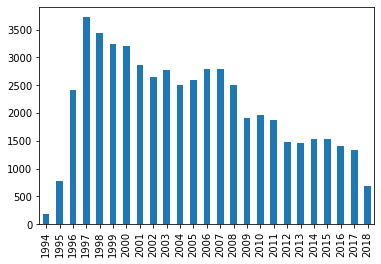

In [34]:
fig, ax = plt.subplots()
df_13d_files['13d_filingYear'].value_counts().sort_index().plot(ax=ax, kind='bar')

### Filing Month - Descriptive Statistic

In [35]:
df_13d_files['13d_filingMonth'].value_counts().sort_index()

1     4564
2     5365
3     4763
4     4376
5     4446
6     4338
7     4205
8     4463
9     3733
10    4517
11    4373
12    4501
Name: 13d_filingMonth, dtype: int64

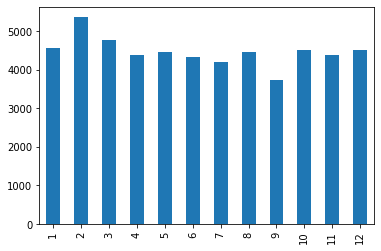

In [36]:
fig, ax = plt.subplots()
df_13d_files['13d_filingMonth'].value_counts().sort_index().plot(ax=ax, kind='bar')

### Summary
In this step we extracted two types of information from the 13D files.
* filing date 
* CIK (central index key) for the filing company

An investigation into the filings dates showed, that while most files (53,770) contain exactly one filing date in the required form, some files (43) do not contain the filing date in the required format. As these files are very old and therefore not in the dataset of our later analysis (which starts in 1998), we disregarded them. We also found 23 files, that contain information on more than 1 filing date. This was partly due to the same filing date named twice or an additional second filing date, which was no more than 3 days later than the original filing date. In the latter case, we used the earlier date given.

An investigation into the ciks showed the following:
* Most files (53,648) contain the term *SUBJECT COMPANY* and *FILING COMPANY* exactly once. These terms are important as they allow us to determine, whether a cik corresponds to the subject or filing company. 13D filings, which did not exactly contain each of these keywords once (188 files), were dropped. 
* Most files (53,664) contained the keyword *CENTRAL INDEX KEY* exactly twice. It's important for this requirement to be fulfilled, as it is very hard and tedious to automatically identify, which cik corresponds to which type of company (subject or filing company). Therefore, all files, that did not meet this requirement (172 files) were dropped.

It should be noted that in the end we have 53,664 13D filings. 
If we simply add up all the times, that we excluded a file we get:

In [37]:
print(f"Number of times, that a file was excluded: \t\t{43+188+172}")
print(f"Number of files actually dropped: \t\t\t{53836-53644}")
print(f"Percentage of files that could be evaluated: \t\t{str(100*(53644/53836))[:5]}%")

Number of times, that a file was excluded: 		403
Number of files actually dropped: 			192
Percentage of files that could be evaluated: 		99.64%


We therefore see, that some of the files caused multiple problems and were discarded at multiple stages. 

We also see, that we had a success rate of more than 99% for evaluating the 13D files.

After extracting the filing date and cik information from the 13D files, we added two additional columns (filing year and filing month), which are used for a discussion in the thesis.